# Created master dataframes: (all in draft_data)
- master_df.csv
- master_df_take2.csv
- master_df.csv


This is for when Arnold and I thought that we couldn't use separate dataframes in Folium. But it turns out, we can!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Send to Shiff

In [2]:
gas_current = pd.read_csv('./data/gas_stations_covid_danger.csv')
gas_current.head()

,name,x,y,county,ordinal_cat,COVID-19 danger
0,Circle K & Minimart,-117.190777,34.057365,San Bernardino,1,Low Risk
1,Unknown Name,-117.225609,34.048575,San Bernardino,3,Medium Risk
2,Unknown Name,-117.156299,34.041388,San Bernardino,1,Low Risk
3,Arco,-122.420268,37.768468,San Francisco,2,Mild Risk
4,Valley Oil,-122.070127,37.381165,Santa Clara,3,Medium Risk


In [3]:
gas_final = gas_current[['name', 'county', 'x', 'y']]

In [4]:
gas_final.head()

,name,county,x,y
0,Circle K & Minimart,San Bernardino,-117.190777,34.057365
1,Unknown Name,San Bernardino,-117.225609,34.048575
2,Unknown Name,San Bernardino,-117.156299,34.041388
3,Arco,San Francisco,-122.420268,37.768468
4,Valley Oil,Santa Clara,-122.070127,37.381165


In [5]:
gas_final.to_csv('./data/gas_for_shiff_preds.csv')

# Clean Covid

In [6]:
df_covid = pd.read_csv('./data/clean_covid_data.csv')
df_covid.head(1)

,date,county,fips,place,confirmed_cases,note,x,y,log_cases,category,ordinal_cat
0,2020-10-23,Sonoma,97.0,Bodega,1,10 or fewer,-122.973889,38.345278,0.0,0,0


In [7]:
df_fire = pd.read_csv('./data/fire_data_clean_withacres.csv')
df_fire.head(1)

,Unnamed: 0,name,x,y,radius,acres_burned,status
0,1270,Far Fire,-121.35014,39.06066,3.637586,38,contained


In [8]:
covid_keep = df_covid[['x', 'y', 'log_cases', 'confirmed_cases']]
covid_keep = covid_keep.rename(columns = {'x':'longitude_covid', 'y':'latitude_covid', 'log_cases':'radius_covid', 'confirmed_cases': 'cases_covid'})

In [9]:
covid_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   longitude_covid  1205 non-null   float64
 1   latitude_covid   1205 non-null   float64
 2   radius_covid     1205 non-null   float64
 3   cases_covid      1205 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 37.8 KB


# Clean Fire

In [10]:
fire_keep = df_fire[['x', 'y', 'acres_burned', 'status']]
fire_keep.head(1)

,x,y,acres_burned,status
0,-121.35014,39.06066,38,contained


In [11]:
acres = fire_keep['acres_burned'].tolist()

In [12]:
sq_meters = [x * 4046 for x in acres]
radius_meters = [np.sqrt(x / np.pi) for x in sq_meters]

In [13]:
sq_feet = [x * 43560 for x in acres]

In [14]:
radius_feet = [np.sqrt(x / np.pi) for x in sq_feet]

In [15]:
# one degree of latitude = 364,000 feet
# one degree of longitude = 288,200 feet

# just take the average of these to get approximate radius
avg_conversion = (364000 + 288200) / 2
radius_degrees = [x / avg_conversion for x in radius_feet]

In [16]:
radius_degrees[:3]

[0.002225922291280859, 0.005640441685356162, 0.0019777838568287467]

In [17]:
fire_keep['radius_meters'] = radius_meters
fire_keep.head(1)

<ipython-input-17-ab692a787747>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_keep['radius_meters'] = radius_meters


,x,y,acres_burned,status,radius_meters
0,-121.35014,39.06066,38,contained,221.222757


In [18]:
fire_keep['radius_acres'] = fire_keep.apply(lambda row: np.sqrt(row['acres_burned'] / np.pi), axis = 1)
fire_keep.head(1)

<ipython-input-18-6d18beb77f2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_keep['radius_acres'] = fire_keep.apply(lambda row: np.sqrt(row['acres_burned'] / np.pi), axis = 1)


,x,y,acres_burned,status,radius_meters,radius_acres
0,-121.35014,39.06066,38,contained,221.222757,3.477898


In [19]:
fire_keep['radius_degrees'] = radius_degrees
fire_keep.head(1)

,x,y,acres_burned,status,radius_meters,radius_acres,radius_degrees
0,-121.35014,39.06066,38,contained,221.222757,3.477898,0.002226


In [20]:
fire_keep = fire_keep[['x', 'y', 'status', 'radius_acres', 'radius_degrees', 'radius_meters']]

In [21]:
fire_keep = fire_keep.rename(columns = {'x':'longitude_fire', 'y':'latitude_fire', 'radius_acres':'radius_acres_fire', 'status': 'status_fire', 'radius_degrees': 'radius_degrees_fire', 'radius_meters': 'radius_meters_fire'})
fire_keep.head(1)

,longitude_fire,latitude_fire,status_fire,radius_acres_fire,radius_degrees_fire,radius_meters_fire
0,-121.35014,39.06066,contained,3.477898,0.002226,221.222757


# Clean Gas

In [22]:
gas_df = pd.read_csv('./data/from_shiff')
gas_df.head(1)
gas_df['0'].unique()

array([3, 2, 0, 1])

In [23]:
gas_keep = gas_df[['name', 'x', 'y', '0']]
gas_keep.head()

,name,x,y,0
0,Circle K & Minimart,-117.190777,34.057365,3
1,Unknown Name,-117.225609,34.048575,3
2,Unknown Name,-117.156299,34.041388,3
3,Arco,-122.420268,37.768468,2
4,Valley Oil,-122.070127,37.381165,3


In [24]:
gas_keep['risk_level_gas'] = gas_keep['0'].map({0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk', 3: 'Very High Risk'})
gas_keep.head(1)

<ipython-input-24-6af1cc09e1a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_keep['risk_level_gas'] = gas_keep['0'].map({0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk', 3: 'Very High Risk'})


,name,x,y,0,risk_level_gas
0,Circle K & Minimart,-117.190777,34.057365,3,Very High Risk


In [25]:
gas_keep = gas_keep[['name', 'x', 'y', 'risk_level_gas']]
gas_keep.head(1)

,name,x,y,risk_level_gas
0,Circle K & Minimart,-117.190777,34.057365,Very High Risk


In [26]:
gas_keep = gas_keep.rename(columns = {'name': 'gas_name', 'x':'longitude_gas', 'y':'latitude_gas', 'risk_level_gas': 'risk_level_gas'})

In [27]:
gas_keep.head(1)

,gas_name,longitude_gas,latitude_gas,risk_level_gas
0,Circle K & Minimart,-117.190777,34.057365,Very High Risk


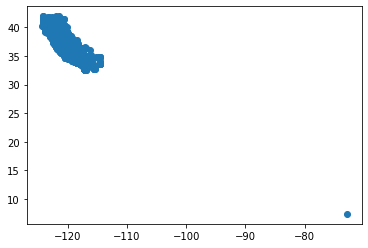

In [28]:
plt.scatter(x = gas_keep['longitude_gas'], y = gas_keep['latitude_gas'])

In [29]:
# remove outlier
gas_keep = gas_keep.loc[gas_keep['longitude_gas'] != gas_keep['longitude_gas'].max()]

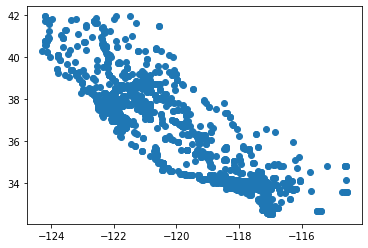

In [30]:
plt.scatter(x = gas_keep['longitude_gas'], y = gas_keep['latitude_gas'])

# put them together

In [31]:
covid_keep.info()
fire_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   longitude_covid  1205 non-null   float64
 1   latitude_covid   1205 non-null   float64
 2   radius_covid     1205 non-null   float64
 3   cases_covid      1205 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 37.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   longitude_fire       93 non-null     float64
 1   latitude_fire        93 non-null     float64
 2   status_fire          93 non-null     object 
 3   radius_acres_fire    93 non-null     float64
 4   radius_degrees_fire  93 non-null     float64
 5   radius_meters_fire   93 non-null     float64
dtypes: float64(5), object(1)
memory usage: 4.5+ KB


In [32]:
covid_len = len(covid_keep.index)
fire_len = len(fire_keep.index)
gas_len = len(gas_keep.index)
gas_len

2926

In [33]:
covid_diff = gas_len - covid_len
fire_diff = gas_len - fire_len

covid_nan_list = [np.nan]*covid_diff
fire_nan_list = [np.nan]*fire_diff

In [34]:
len(fire_nan_list)

2833

In [35]:
fire_keep.head(1)

,longitude_fire,latitude_fire,status_fire,radius_acres_fire,radius_degrees_fire,radius_meters_fire
0,-121.35014,39.06066,contained,3.477898,0.002226,221.222757


In [36]:
fire_df_list1 = fire_keep['longitude_fire'].tolist()
fire_df_col1 = fire_df_list1 + fire_nan_list

fire_df_list2 = fire_keep['latitude_fire'].tolist()
fire_df_col2 = fire_df_list2 + fire_nan_list

fire_df_list3 = fire_keep['radius_acres_fire'].tolist()
fire_df_col3 = fire_df_list3 + fire_nan_list

fire_df_list4 = fire_keep['radius_degrees_fire'].tolist()
fire_df_col4 = fire_df_list4 + fire_nan_list

fire_df_list5 = fire_keep['radius_meters_fire'].tolist()
fire_df_col5 = fire_df_list5 + fire_nan_list

fire_df_list6 = fire_keep['status_fire'].tolist()
fire_df_col6 = fire_df_list6 + fire_nan_list

len(fire_df_col4)

2926

In [37]:
fire_df_real_dict = {'longitude_fire':fire_df_col1,'latitude_fire':fire_df_col2, 'radius_acres_fire': fire_df_col3, 'radius_degrees_fire': fire_df_col4,'radius_meters_fire': fire_df_col5, 'status_fire':fire_df_col6}
fire_df_real = pd.DataFrame(fire_df_real_dict)
fire_df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   longitude_fire       93 non-null     float64
 1   latitude_fire        93 non-null     float64
 2   radius_acres_fire    93 non-null     float64
 3   radius_degrees_fire  93 non-null     float64
 4   radius_meters_fire   93 non-null     float64
 5   status_fire          93 non-null     object 
dtypes: float64(5), object(1)
memory usage: 137.3+ KB


In [38]:
covid_df_list1 = covid_keep['longitude_covid'].tolist()
covid_df_col1 = covid_df_list1 + covid_nan_list

covid_df_list2 = covid_keep['latitude_covid'].tolist()
covid_df_col2 = covid_df_list2 + covid_nan_list

covid_df_list3 = covid_keep['radius_covid'].tolist()
covid_df_col3 = covid_df_list3 + covid_nan_list

covid_df_list4 = covid_keep['cases_covid'].tolist()
covid_df_col4 = covid_df_list4 + covid_nan_list

len(covid_df_col3)

2926

In [39]:
covid_df_real_dict = {'longitude_covid':covid_df_col1,'latitude_covid':covid_df_col2, 'radius_covid': covid_df_col3, 'cases_covid': covid_df_col4}
covid_df_real = pd.DataFrame(covid_df_real_dict)
covid_df_real.head()

,longitude_covid,latitude_covid,radius_covid,cases_covid
0,-122.973889,38.345278,0.0,1.0
1,-120.885787,40.081003,0.0,1.0
2,-121.940086,39.809273,0.0,1.0
3,-116.231396,33.831128,0.0,1.0
4,-122.857675,38.101176,0.0,1.0


In [40]:
gas_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gas_name        2926 non-null   object 
 1   longitude_gas   2926 non-null   float64
 2   latitude_gas    2926 non-null   float64
 3   risk_level_gas  2926 non-null   object 
dtypes: float64(2), object(2)
memory usage: 114.3+ KB


In [41]:
gas_df_real = gas_keep
gas_df_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gas_name        2926 non-null   object 
 1   longitude_gas   2926 non-null   float64
 2   latitude_gas    2926 non-null   float64
 3   risk_level_gas  2926 non-null   object 
dtypes: float64(2), object(2)
memory usage: 114.3+ KB


In [42]:
gas_df_real['risk_level_gas'].tail()

2922    Very High Risk
2923    Very High Risk
2924    Very High Risk
2925    Very High Risk
2926          Low Risk
Name: risk_level_gas, dtype: object

# Merge everything together

In [43]:
fire_df_real.head()

,longitude_fire,latitude_fire,radius_acres_fire,radius_degrees_fire,radius_meters_fire,status_fire
0,-121.350140,39.060660,3.477898,0.002226,221.222757,contained
1,-120.296551,37.524378,8.812923,0.005640,560.573955,contained
2,-122.435492,40.463936,3.090194,0.001978,196.561578,contained
3,-121.468074,37.962557,5.352372,0.003426,340.454640,contained
4,-120.027731,37.241427,6.886812,0.004408,438.057517,contained


In [44]:
df_covid_fire = covid_df_real.join(fire_df_real, how='outer')
df_covid_fire.head()

,longitude_covid,latitude_covid,radius_covid,cases_covid,longitude_fire,latitude_fire,radius_acres_fire,radius_degrees_fire,radius_meters_fire,status_fire
0,-122.973889,38.345278,0.0,1.0,-121.350140,39.060660,3.477898,0.002226,221.222757,contained
1,-120.885787,40.081003,0.0,1.0,-120.296551,37.524378,8.812923,0.005640,560.573955,contained
2,-121.940086,39.809273,0.0,1.0,-122.435492,40.463936,3.090194,0.001978,196.561578,contained
3,-116.231396,33.831128,0.0,1.0,-121.468074,37.962557,5.352372,0.003426,340.454640,contained
4,-122.857675,38.101176,0.0,1.0,-120.027731,37.241427,6.886812,0.004408,438.057517,contained


In [45]:
df_final = df_covid_fire.join(gas_df_real, how = 'outer')
df_final.head()

,longitude_covid,latitude_covid,radius_covid,cases_covid,longitude_fire,latitude_fire,radius_acres_fire,radius_degrees_fire,radius_meters_fire,status_fire,gas_name,longitude_gas,latitude_gas,risk_level_gas
0,-122.973889,38.345278,0.0,1.0,-121.350140,39.060660,3.477898,0.002226,221.222757,contained,Circle K & Minimart,-117.190777,34.057365,Very High Risk
1,-120.885787,40.081003,0.0,1.0,-120.296551,37.524378,8.812923,0.005640,560.573955,contained,Unknown Name,-117.225609,34.048575,Very High Risk
2,-121.940086,39.809273,0.0,1.0,-122.435492,40.463936,3.090194,0.001978,196.561578,contained,Unknown Name,-117.156299,34.041388,Very High Risk
3,-116.231396,33.831128,0.0,1.0,-121.468074,37.962557,5.352372,0.003426,340.454640,contained,Arco,-122.420268,37.768468,High Risk
4,-122.857675,38.101176,0.0,1.0,-120.027731,37.241427,6.886812,0.004408,438.057517,contained,Valley Oil,-122.070127,37.381165,Very High Risk


In [46]:
df_final.to_csv('./data/master_df_take3.csv', index = False)

In [37]:
covid_df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   longitude_covid  1205 non-null   float64
 1   latitude_covid   1205 non-null   float64
 2   radius_covid     1205 non-null   float64
dtypes: float64(3)
memory usage: 68.7 KB


In [38]:
fire_df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   longitude_fire  93 non-null     float64
 1   latitude_fire   93 non-null     float64
 2   radius_fire     93 non-null     float64
 3   status_fire     93 non-null     object 
dtypes: float64(3), object(1)
memory usage: 91.6+ KB


In [39]:
gas_df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gas_name        2927 non-null   object 
 1   longitude_gas   2927 non-null   float64
 2   latitude_gas    2927 non-null   float64
 3   risk_level_gas  2927 non-null   object 
dtypes: float64(2), object(2)
memory usage: 91.6+ KB


In [40]:
df_final

,longitude_covid,latitude_covid,radius_covid,longitude_fire,latitude_fire,radius_fire,status_fire,gas_name,longitude_gas,latitude_gas,risk_level_gas
0,-122.973889,38.345278,0.0,-121.350140,39.060660,3.477898,contained,Circle K & Minimart,-117.190777,34.057365,Very High Risk
1,-120.885787,40.081003,0.0,-120.296551,37.524378,8.812923,contained,Unknown Name,-117.225609,34.048575,Very High Risk
2,-121.940086,39.809273,0.0,-122.435492,40.463936,3.090194,contained,Unknown Name,-117.156299,34.041388,Very High Risk
3,-116.231396,33.831128,0.0,-121.468074,37.962557,5.352372,contained,Arco,-122.420268,37.768468,High Risk
4,-122.857675,38.101176,0.0,-120.027731,37.241427,6.886812,contained,Valley Oil,-122.070127,37.381165,Very High Risk
...,...,...,...,...,...,...,...,...,...,...,...
2922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pilot,-117.087724,34.854655,Very High Risk
2923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown Name,-117.850397,33.823337,Very High Risk
2924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shell,-117.034808,32.594424,Very High Risk
2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mobil,-117.738206,33.861640,Very High Risk
